In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

sys.path.append(os.path.join(project_root, 'source'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, savgol_filter

from data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data
from power_calculator import compute_eeg_power

from sync_artefact_finder import find_eeg_peak, find_dbs_peak, detect_eeg_drop_onset_window

In [3]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009']

block = 'pre8walk'

dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


In [4]:
file_info = [
    {"sub_id": "P4-2001", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"},
    {"sub_id": "P4-2002", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json"},
    {"sub_id": "P4-2003", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json"},
    {"sub_id": "P4-2004", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json"},
    {"sub_id": "P4-2005", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json"},
    {"sub_id": "P4-2007", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json"},
    {"sub_id": "P4-2008", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json"},
    {"sub_id": "P4-2009", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json"},
    {"sub_id": "P4-2010", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json"},
]

Processing P4-2001 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


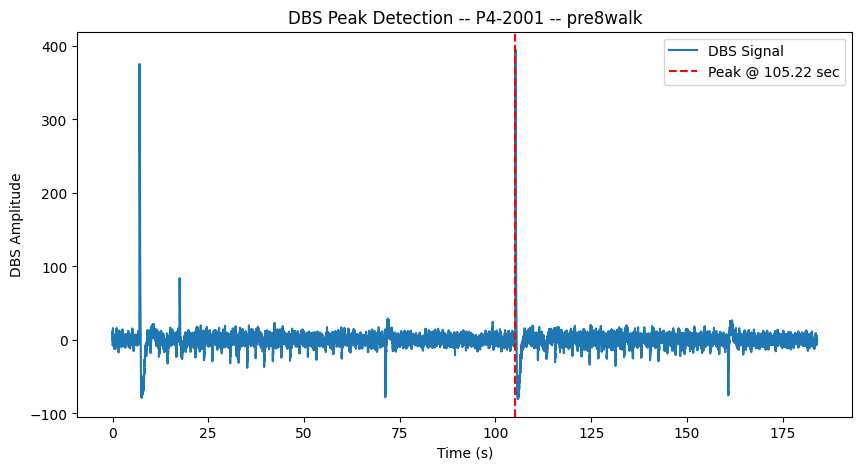

Processing P4-2002 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


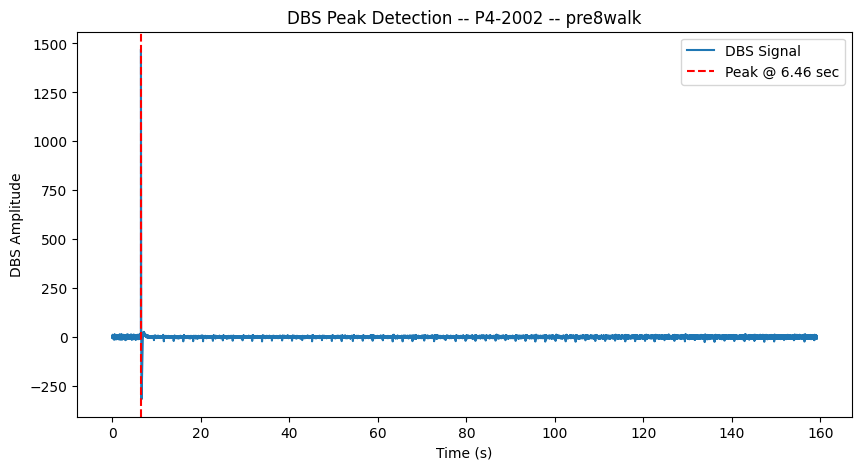

Processing P4-2003 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


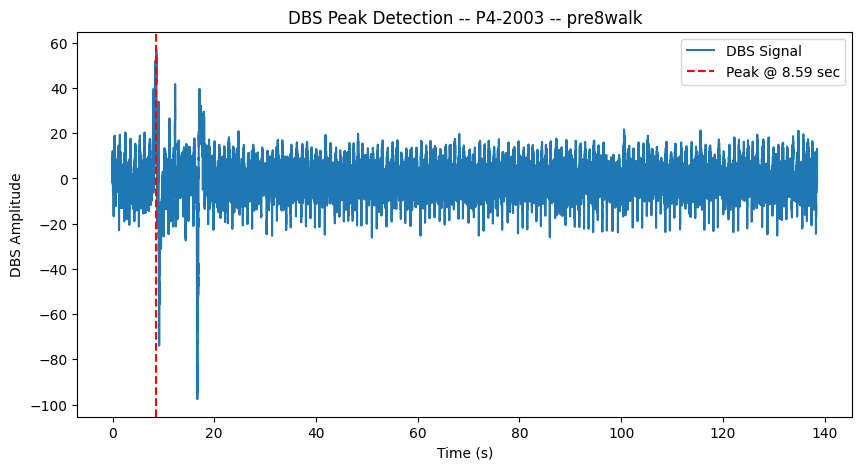

Processing P4-2004 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


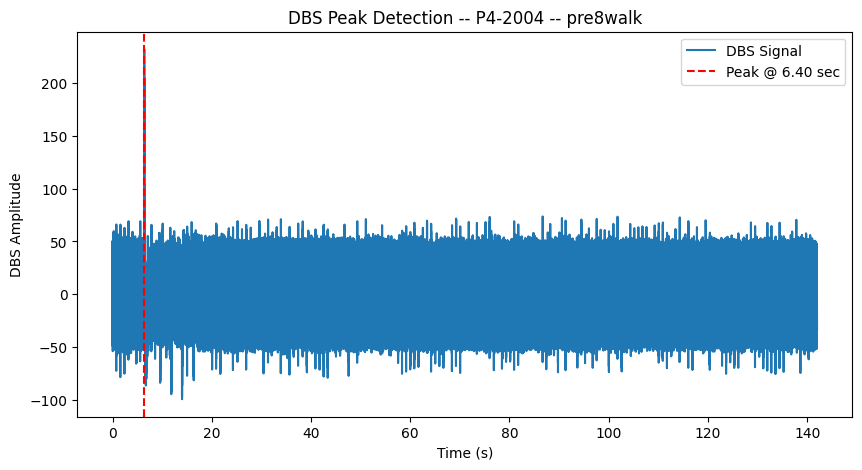

Processing P4-2005 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


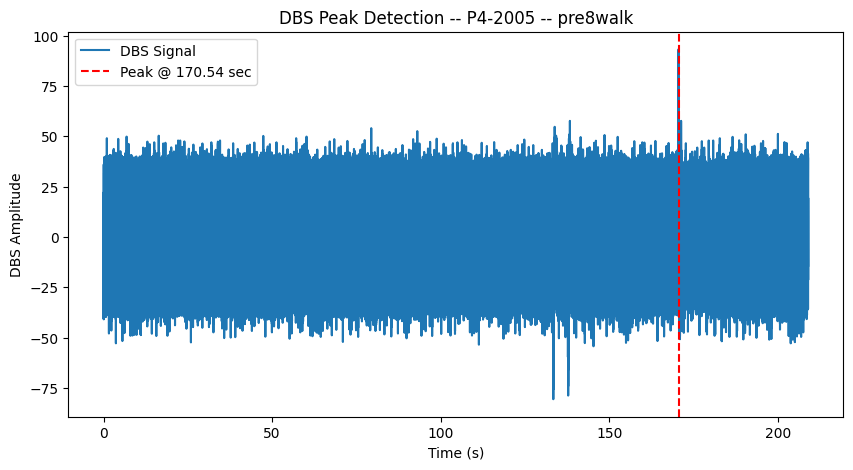

Processing P4-2007 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


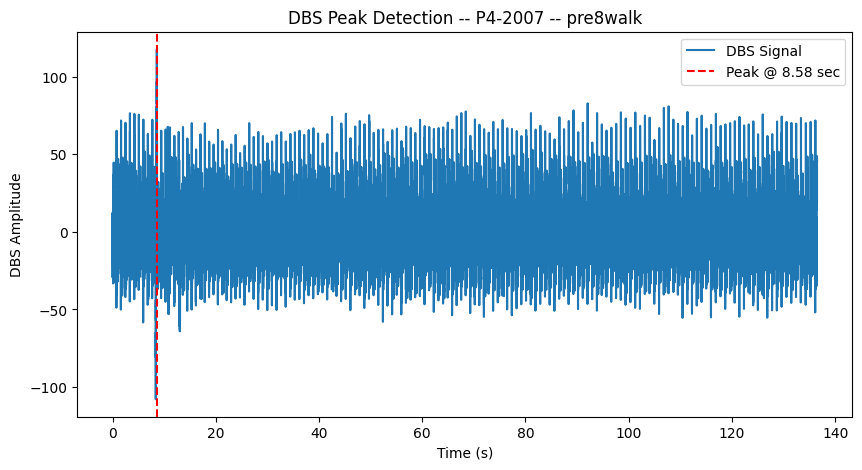

Processing P4-2008 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


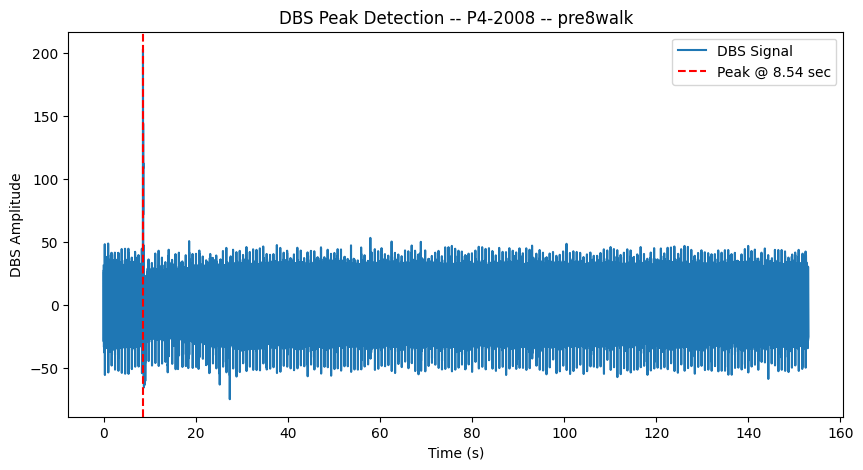

Processing P4-2009 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


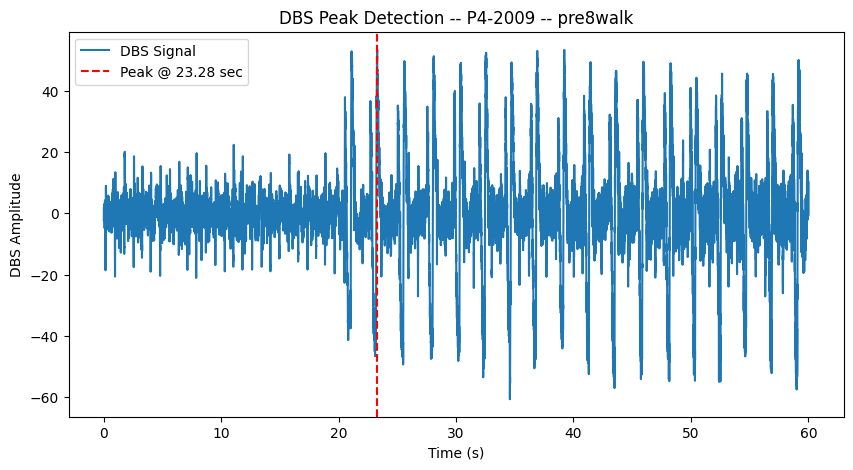

Processing P4-2010 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


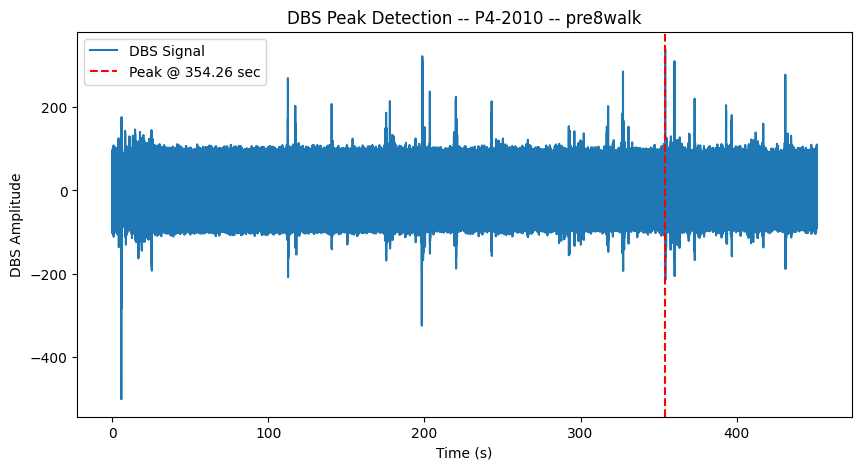

In [5]:
for file in file_info:
    sub_id = file["sub_id"]
    dbs_path = file["file_path"]
    print(f"Processing {sub_id} from {dbs_path}")
    # Load DBS
    json_data = open_json_file(dbs_path)
    # block_num = select_recording(json_data)
    block_num = 0  # Assuming you want to process the first block
    dbs_data = read_time_domain_data(json_data, block_num)

    # Extract DBS signal
    dbs_signal = dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]

    # Compute time axis
    dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

    # Find peaks **only in the positive direction**
    peaks, _ = find_peaks(dbs_signal, height=0)  # Only positive peaks

    if len(peaks) > 0:
        # Select the **highest** positive peak
        dbs_peak_index_fs = peaks[np.argmax(dbs_signal[peaks])]
    else:
        # Fallback: Use max value in the first 1000 samples
        dbs_peak_index_fs = np.argmax(dbs_signal[:1000])

    dbs_peak_index_s = dbs_peak_index_fs / dbs_fs

    # Plot detected peak
    plt.figure(figsize=(10, 5))
    plt.plot(dbs_time_axis, dbs_signal, label="DBS Signal")
    plt.axvline(dbs_time_axis[dbs_peak_index_fs], color='r', linestyle='--', label=f'Peak @ {dbs_peak_index_s:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('DBS Amplitude')
    plt.title(f'DBS Peak Detection -- {sub_id} -- {block}')
    plt.legend()

    plt.show()

Processing P4-2001 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


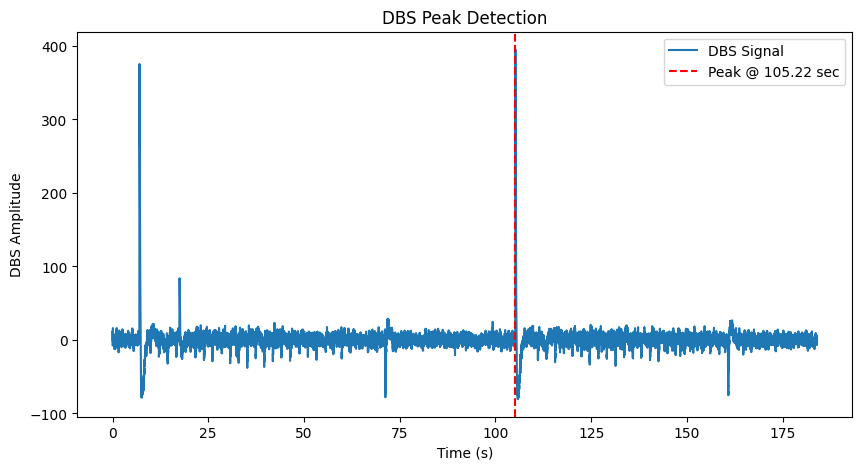

Processing P4-2002 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


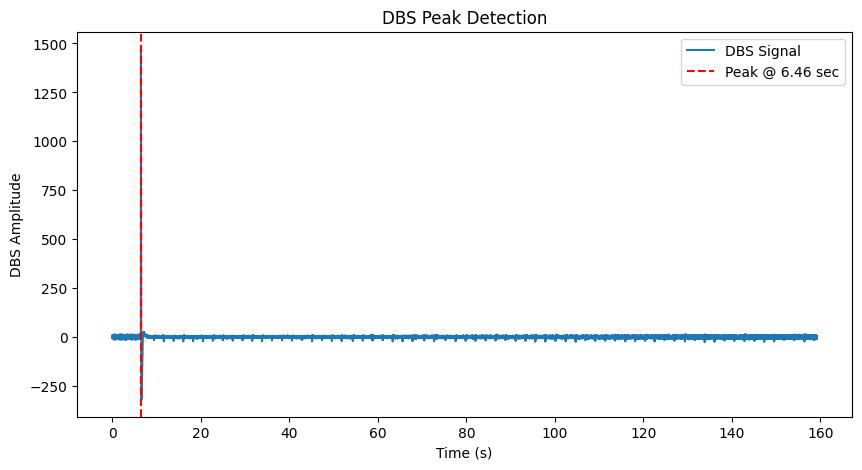

Processing P4-2003 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


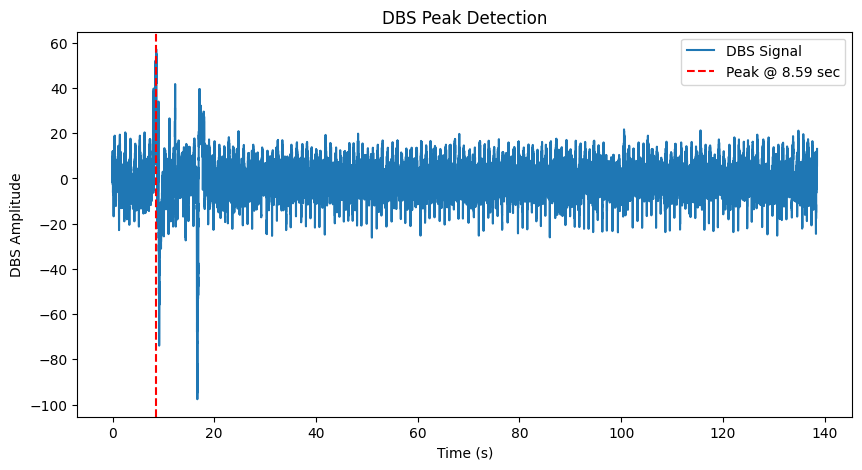

Processing P4-2004 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


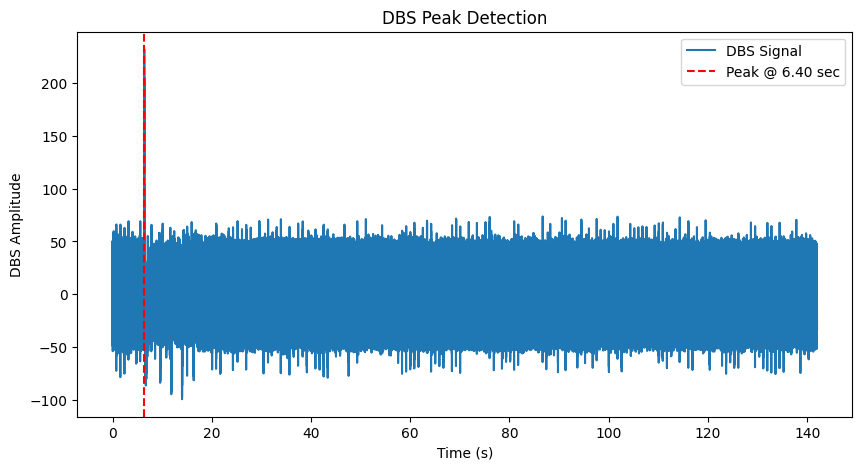

Processing P4-2005 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


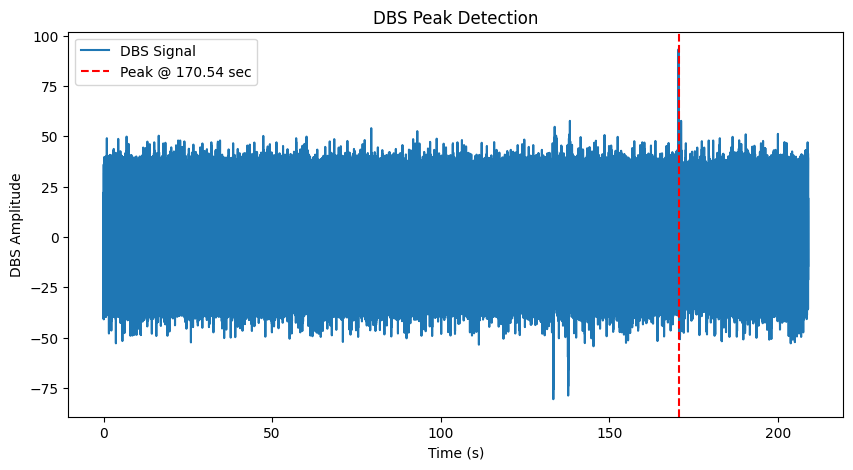

Processing P4-2007 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


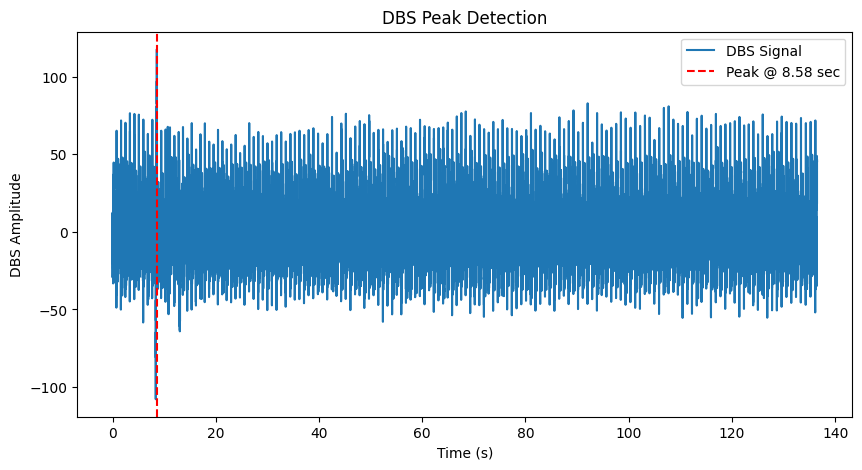

Processing P4-2008 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


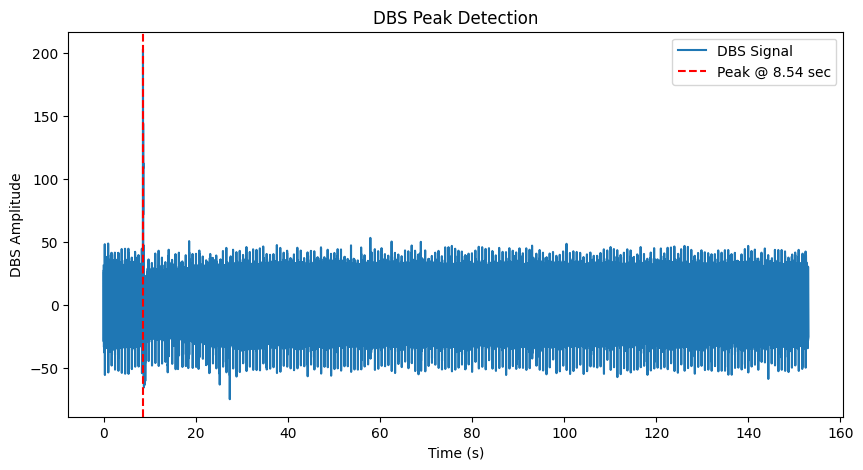

Processing P4-2009 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


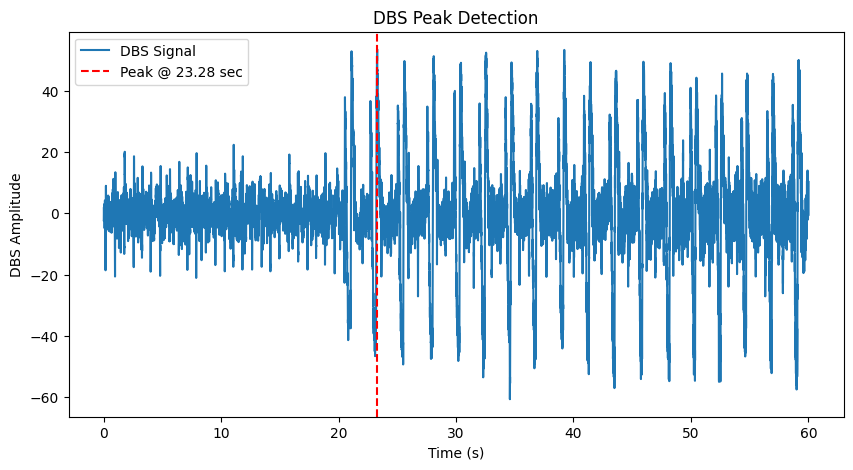

Processing P4-2010 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


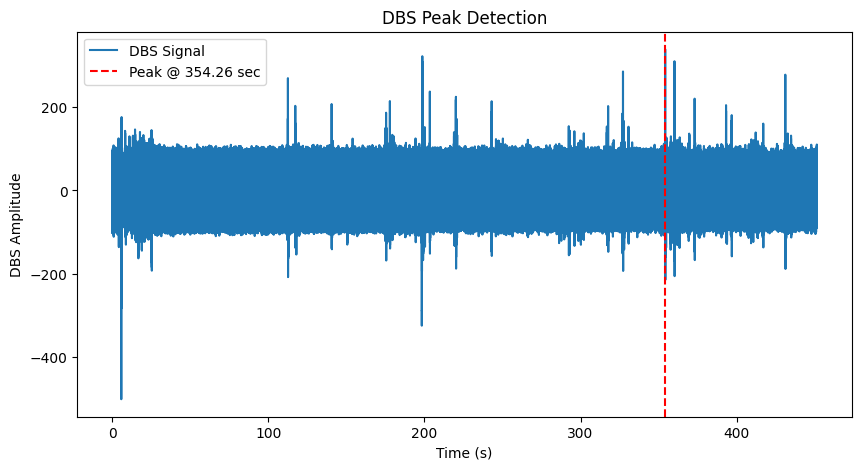

In [8]:
for file in file_info:
    sub_id = file["sub_id"]
    dbs_path = file["file_path"]
    print(f"Processing {sub_id} from {dbs_path}")
    # Load DBS
    json_data = open_json_file(dbs_path)
    # block_num = select_recording(json_data)
    block_num = 0  # Assuming you want to process the first block
    dbs_data = read_time_domain_data(json_data, block_num)

    # Find DBS peak
    dbs_signal =  dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]
    dbs_peak_idx, dbs_peak_time = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None)

    # Compute time axis
    dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs
